# Logistic Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

## Load and examine American National Election Studies (ANES) data
These data are from the 2016 pilot study. The full study consisted of 1200 people, but here we've selected the subset of 487 people who responded to a question about whether they would vote for Hillary Clinton or Donald Trump. 

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is `vote`, which gives peoples' responses to the following question prompt:

_"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"_

In [4]:
data["vote"].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

The two predictors we'll examine are a respondent's `age` and their political party affiliation, `party_id`, which is their response to the following question prompt:

_"Generally speaking, do you usually think of yourself as a Republican, a Democrat, an
independent, or what?"_

In [5]:
data["party_id"].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

These two predictors are somewhat correlated, but not all that much:

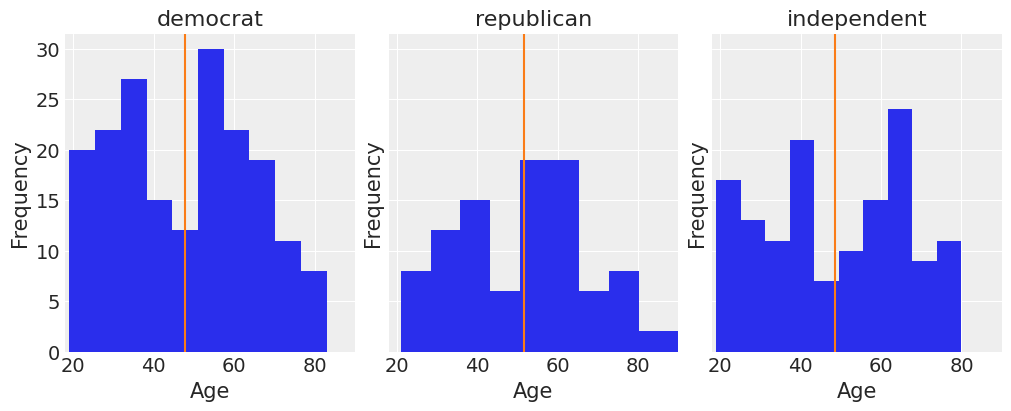

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data["party_id"].unique(), range(3)))
for label, df in data.groupby("party_id"):
    ax[key[label]].hist(df["age"])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel("Age")
    ax[key[label]].set_ylabel("Frequency")
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df["age"].mean(), color="C1")

We can get a pretty clear idea of how party identification is related to voting intentions by just looking at a contingency table for these two variables:

In [7]:
pd.crosstab(data["vote"], data["party_id"])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


But our main question here will be: How is respondent age related to voting intentions, and is this relationship different for different party affiliations? For this we will use a logistic regression.

## Build `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [8]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


### Logistic regression
We'll use a logistic regression model to estimate the probability of voting for Clinton as a function of age and party affiliation. We can think we have a response variable $Y$ defined as

$$
Y = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person votes for Clinton} \\
        0 & \textrm{if the person votes for Trump} 
    \end{array}
\right.
$$

and we are interested in modelling $\pi = P(Y = 1)$ (a.k.a. probability of success) based on two explanatory variables, age and party affiliation. 

A logistic regression is a model that links the $\text{logit}(\pi)$ to a linear combination of the predictors. In our example, we're going to include a main effect for party affiliation and the interaction effect between party affiliation and age (i.e. we'll have a different age slope for each affiliation). The mathematical equation for our model is

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = 
\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 X_4 + \beta_4 X_1 X_4 + \beta_5 X_2 X_4
$$

$$
X_1 = \left\{ 
    \begin{array}{ll}
        1 & \textrm{if party affiliation is Independent} \\
        0 & \textrm{in other case} 
    \end{array}
\right. \\
$$

$$
X_2 = \left\{ 
    \begin{array}{ll}
        1 & \textrm{if party affiliation is Republican} \\
        0 & \textrm{in other case} 
    \end{array}
\right. \\
$$

$$
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if party affiliation is Democrat} \\
        0 & \textrm{in other case} 
    \end{array}
\right. \\
$$

$$
X_4 = \text{Age}
$$

Notice we don't have a main effect for $X_3$. This happens because Democrat party affiliation is being taken as baseline in the encoding of the categorical variable `party_id` and $\beta_1$ and $\beta_2$ represent deviations from that baseline. Thus, we see the main effect of Democrat affiliation is being represented by the Intercept, $\beta_0$. 

If we represent the right hand side of the model equation with $\eta$, the expression can be re-arranged to express our probability of interest, $\pi$, as a function of the linear predictor $\eta$.

$$\pi = \frac{e^\eta}{1 + e^\eta}= \frac{1}{1 + e^{-\eta}}$$

Since we're Bayesian folks who draw samples from posteriors, we need to specify a prior for the parameters as well as a likelihood function before accomplishing our task. In this occasion, we're going to use the default priors in Bambi and just note the likelihood is the product of $n$ Bernoulli trials, $\prod_{i=1}^{n}{p_i^y(1-p_i)^{1-y_i}}$ where $p_i = P(Y=1)$ and $y_i = 1$ if the vote intention is for Clinton and $y_i = 0$ if Trump.

### Specify and fit model in Bambi
Specifying and fitting the model is simple. Bambi is good and doesn't ask us to translate all the math to code. We just need to specify our model using the formula syntax and pass the correct `family` argument. Notice the (optional) syntax that we use on the left-hand-side of the formula: We say `vote[clinton]` to instruct Bambi that we wish the model the probability that `vote=='clinton'`, rather than the probability that `vote=='trump'`. If we leave this unspecified, Bambi will just pick one of the events to model, but will inform you which one it picked when you build the model (and again when you look at model summaries).

On the right-hand-side of the formula we use `party_id + party_id:age` to instruct Bambi that we want to use `party_id` and the interaction between `party_id` and `age` as the explanatory variables in the model.

<!--When fitting models using the `pymc3` backend, the default estimation strategy is to start with an identity mass matrix, but add uniform jitter in [-1, 1] and then adapt a diagonal based on the variance of the tuning draws. This generally works quite well, but occasionally it can fails. That's what was happening for this particular data set and model, so below we disable the `jitter+adapt_diag` initialization by changing from `init='auto'` (the default) to `init=adapt_diag`, which tells the `pymc3` backend to drop the jitter step.-->

In [9]:
clinton_model = bmb.Model("vote['clinton'] ~ party_id + party_id:age", clinton_data, family="bernoulli")
clinton_fitted = clinton_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


We can print the model object to see information about the response distribution, the link function and the priors. 

In [10]:
clinton_model

Formula: vote['clinton'] ~ party_id + party_id:age
Family name: Bernoulli
Link: logit
Observations: 373
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3846)
    party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
    party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0938 0.1007 0.1098])


------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Under the hood, Bambi selected Gaussian priors for all the parameters in the model. By construction, all the priors, except the one for `Intercept`, are centered around 0, which is consistent with the desired weakly informative behavior. The standard deviation is specific to each parameter. 

Some more info about these default priors can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

We can also call `clinton_model.plot_priors()` to visualize the sensitive default priors Bambi has chosen for us.

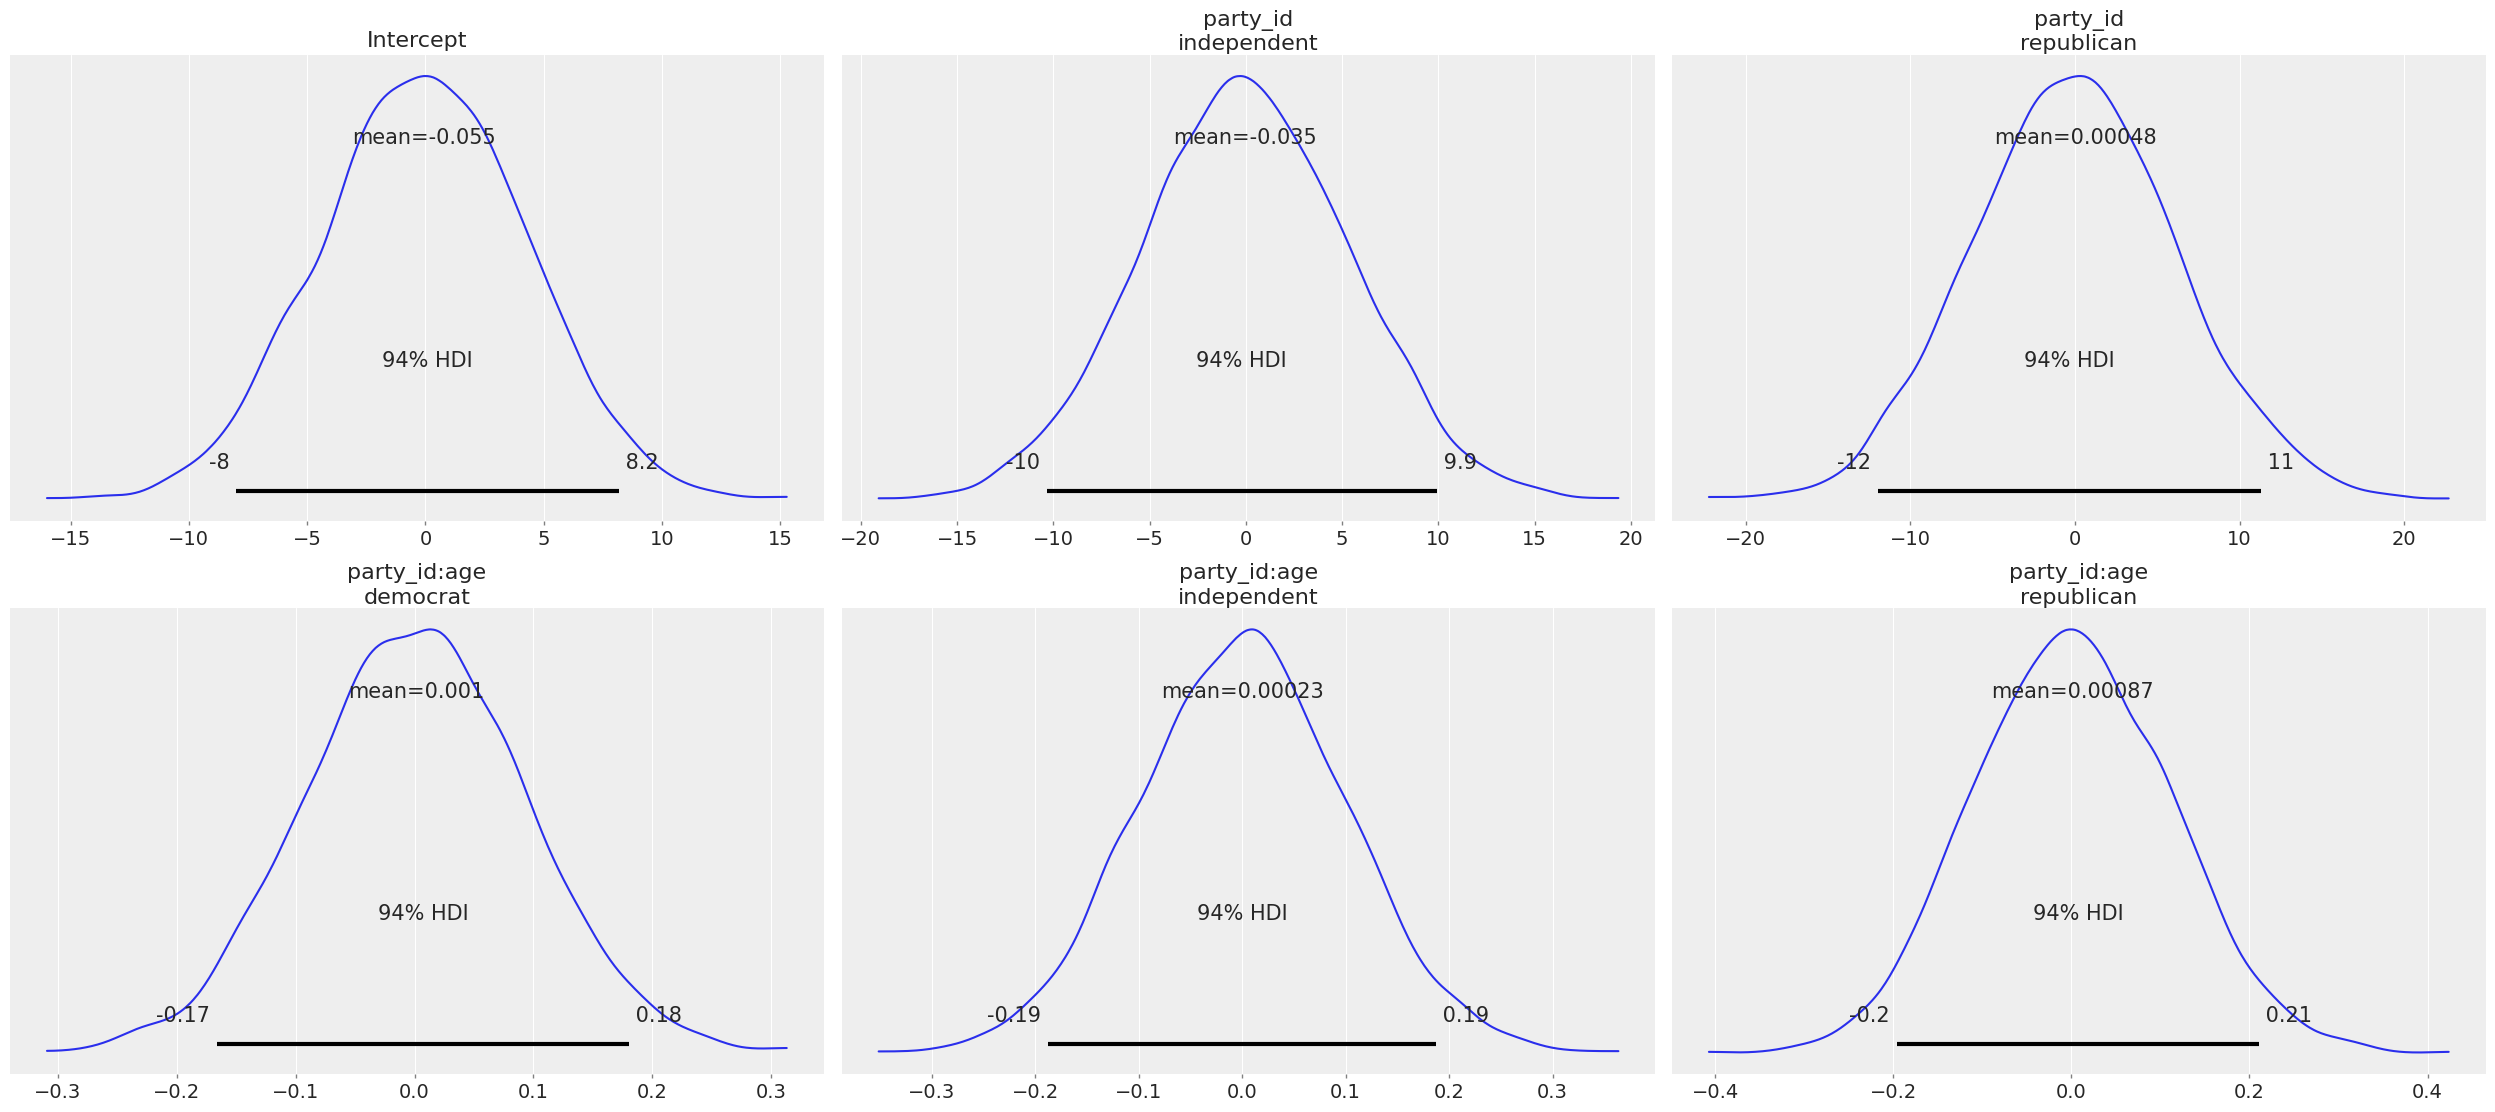

In [11]:
clinton_model.plot_priors();

Now let's check out the results! We get traceplots and density estimates for the posteriors with `az.plot_trace()` and a summary of the posteriors with `az.summary()`.

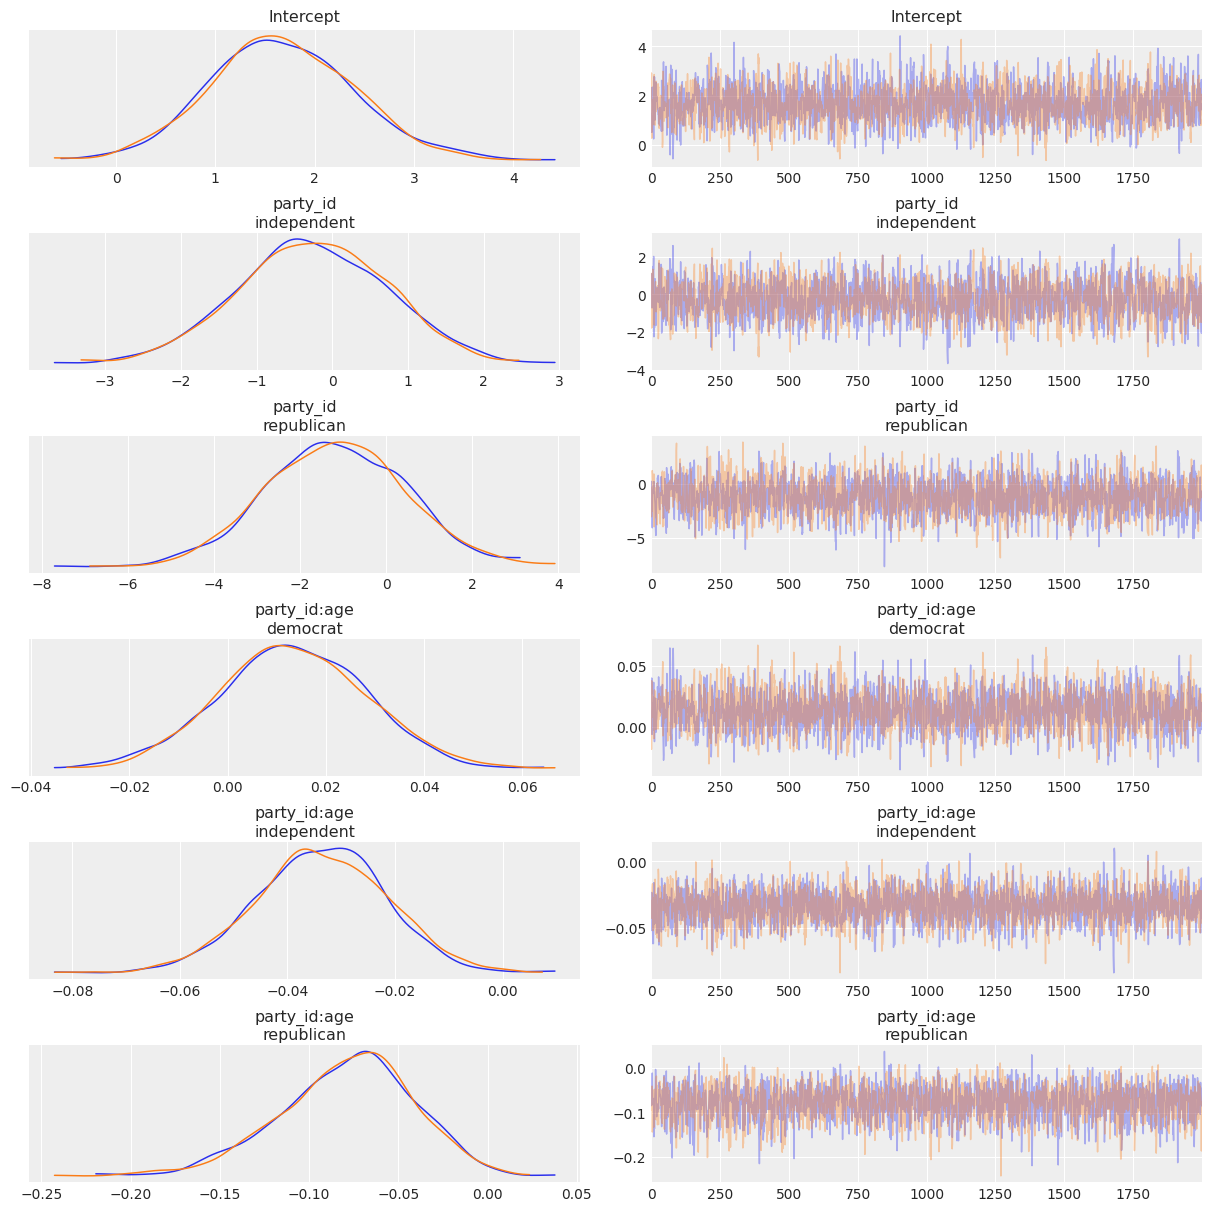

In [12]:
az.plot_trace(clinton_fitted, compact=False);

In [13]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.668,0.726,0.308,3.056,0.015,0.011,2261.0,2154.0,1.0
party_id[independent],-0.260,0.972,-2.036,1.598,0.022,0.017,1926.0,1969.0,1.0
party_id[republican],-1.163,1.602,-4.085,1.955,0.034,0.025,2218.0,2102.0,1.0
party_id:age[democrat],0.013,0.015,-0.016,0.041,0.000,0.000,2176.0,2281.0,1.0
party_id:age[independent],-0.034,0.012,-0.057,-0.012,0.000,0.000,2767.0,2477.0,1.0
party_id:age[republican],-0.079,0.037,-0.152,-0.015,0.001,0.001,2333.0,1977.0,1.0


# Model assessment
Before moving forward to inference, we can evaluate the quality of the model's fit. We will take a look at two different ways of assessing how good is the model's fit using its predictions. 

## Separation plot

There is a way of assessing the performance of a model with binary outcomes (such as logistic regression) in a visual way called [separation plot](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-5907.2011.00525.x). In a separation plot, the model's predictions are averaged, ordered and represented as consecutive vertical lines. These vertical lines are colored according to the class indicated by their corresponding observed value, in this case light blue indicates class 0 (`vote == 'Trump'`) and blue represents class 1 (`vote =='Clinton'`). We can use the ArviZ' implementation of the separation plot, but first we have to obtain the model's predictions.

In [14]:
clinton_model.predict(clinton_fitted, kind="pps")

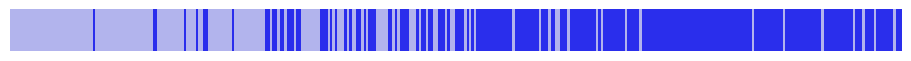

In [15]:
ax = az.plot_separation(clinton_fitted, y='vote', figsize=(9,0.5));

In this separation plot we can see that some observations are misspredicted, specially in the right hand side of the plot where the model predicts Trump votes when there were really Clinton ones. We can further investigate this using another of ArviZ model evaluation tool.

## $\hat \kappa$ parameter
We can also use ArviZ to compute [LOO](https://arxiv.org/abs/1507.04544) and find influential observations using the estimated $\hat \kappa$ parameter value.  

In [16]:
# compute pointwise LOO
loo = az.loo(clinton_fitted, pointwise=True)

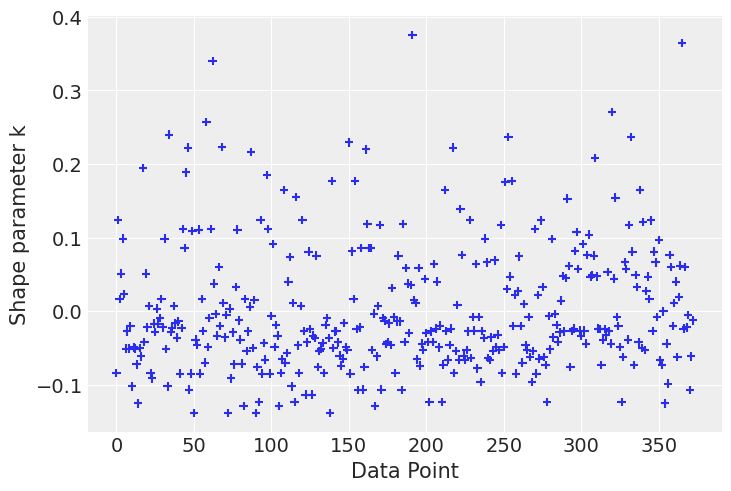

In [17]:
# plot kappa values
az.plot_khat(loo.pareto_k);

A first look at the khat plot shows that most observations' $\hat \kappa$ values are grouped together in a range that goes up to roughly 0.2. Above that value, we observe some dispersion and a few points that stand out by having the highest $\hat \kappa$ values. 

An observation is influential in the sense that if we refit the data by first removing that observation from the data set, the fitted result will be more different than if we do the same for a non influential observation. Clearly the level of influence of observations can vary continuously. An observation can be influential either because it is an outlier (a measurement error, a data entry error, etc) or because the model is not flexible enough to capture the observation. The approximations used to compute LOO are no longer reliable for $\hat \kappa > 0.7$.

Let us first take a look at the observation with the highest $\hat \kappa$.

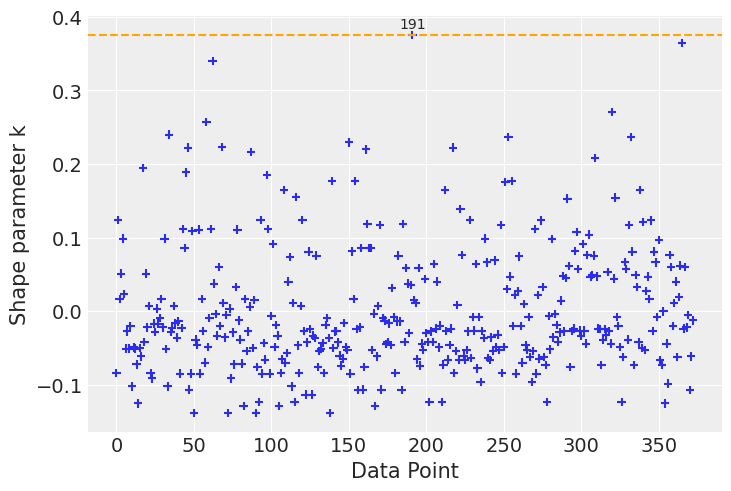

In [18]:
ax = az.plot_khat(loo.pareto_k.values.ravel())
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-1:]
ax.axhline(threshold, ls="--", color="orange")
influential_observations = clinton_data.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [19]:
clinton_data.reset_index()[loo.pareto_k.values >= threshold]

,index,vote,age,party_id
191,215,trump,95,republican


This observation corresponds to a 95 year old Republican party member that voted for Trump. 

<!-- If this observation doesn't appear unusual to you right now, the model's difficulty in prediciting with that observation will definetly make sense in the next section. -->

Let us take a look at six observations with the highest $\hat \kappa$ values.

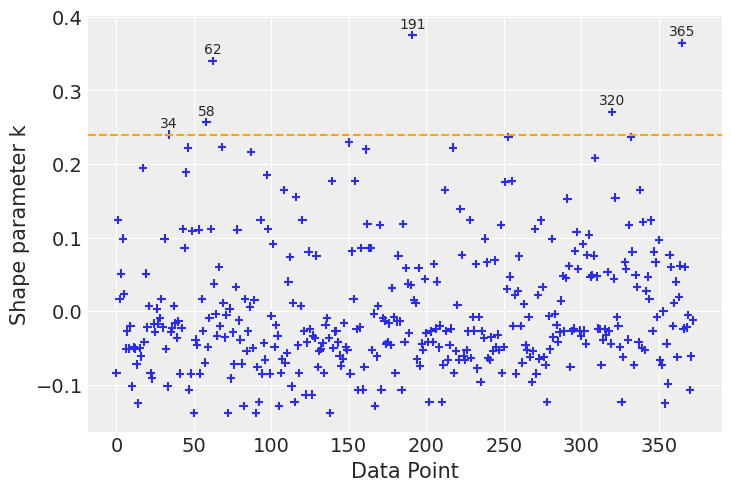

In [20]:
ax = az.plot_khat(loo.pareto_k)

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-6:].min()
ax.axhline(threshold, ls="--", color="orange")
influential_observations = clinton_data.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [21]:
clinton_data.reset_index()[loo.pareto_k.values>=threshold]

,index,vote,age,party_id
34,34,trump,83,republican
58,64,trump,84,republican
62,68,trump,91,republican
191,215,trump,95,republican
320,359,clinton,22,republican
365,410,clinton,55,republican


Observations number 34, 58, 62, and 191 correspond to individuals in under represented age groups in the data set. The rest correspond to Republican party members that voted for Clinton. Let us check how many observations we have of individuals older than 80 years old.

In [22]:
clinton_data[clinton_data.age>80]

,vote,age,party_id
34,trump,83,republican
64,trump,84,republican
68,trump,91,republican
97,clinton,83,democrat
215,trump,95,republican
246,clinton,82,democrat
403,clinton,81,democrat


Let us check how many observations there are of Republicans who voted for Clinton

In [23]:
clinton_data[(clinton_data.vote =='clinton') & (clinton_data.party_id == 'republican')]

,vote,age,party_id
170,clinton,27,republican
248,clinton,36,republican
359,clinton,22,republican
361,clinton,37,republican
410,clinton,55,republican


There are only two observations for individuals older than 80 years old and five observations for individuals of the Republican party that vote for Clinton. The fact that the model finds it difficult to predict for these observations is related to model uncertainty, due to a scarce number of observations that exhibit these characteristics.

Let us repeat the separation plot, this time marking the observations we have analyzed. This plot will show us how the model predicted these particular observations.

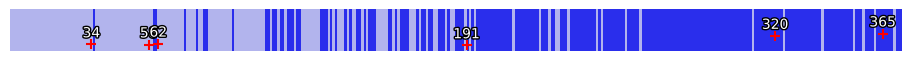

In [24]:
import matplotlib.patheffects as pe

ax = az.plot_separation(clinton_fitted, y="vote", figsize=(9, 0.5))

y = np.random.uniform(0.1, 0.5, size=len(influential_observations))

for x, y in zip(influential_observations, y):
    text = str(x)
    x = x / len(clinton_data)
    ax.scatter(x, y, marker="+", s=50, color="red", zorder=3)
    ax.text(
        x, y + 0.1, text, color="white", ha="center", va="bottom",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

In [25]:
clinton_data.reset_index()[loo.pareto_k.values>=threshold]

,index,vote,age,party_id
34,34,trump,83,republican
58,64,trump,84,republican
62,68,trump,91,republican
191,215,trump,95,republican
320,359,clinton,22,republican
365,410,clinton,55,republican


This assessment helped us to further understand the model and quality of the fit. It also illustrates the intuition that we should be cautious when predicting for under represented age groups and voting behaviours.

## Run Inference

Grab the posteriors samples of the `age` slopes for the three `party_id` categories.

In [26]:
# We need to automatically add labels to InferenceData object to recover this by_label selection
parties = ["democrat", "independent", "republican"]
party_idx = [0, 1, 2]
dem, ind, rep = [clinton_fitted.posterior["party_id:age"][:, :, x].values for x in party_idx]

Plot the marginal posteriors for the `age` slopes for the three political affiliations.

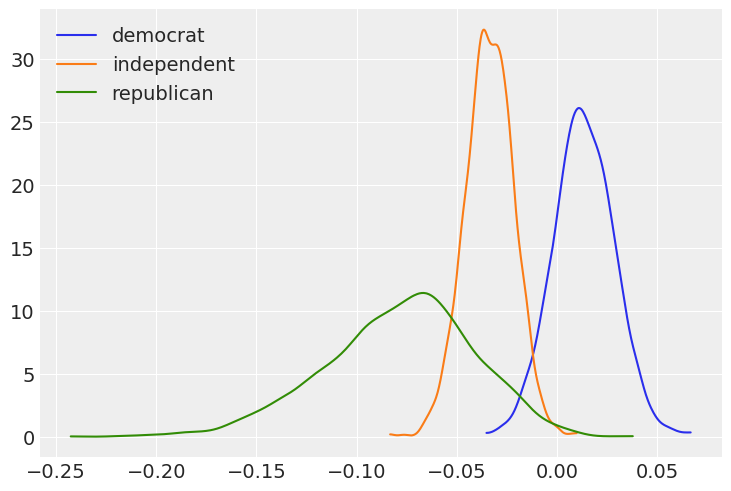

In [27]:
fig, ax = plt.subplots()
for idx, x in enumerate([dem, ind, rep]):
    az.plot_kde(x, label=f"{parties[idx]}", plot_kwargs={"color": f"C{idx}"}, ax=ax)
ax.legend(loc="upper left");

Now, using the joint posterior, we can answer our questions in terms of probabilities.  

What is the probability that the Democrat slope is greater than the Republican slope?

In [28]:
(dem > rep).mean()

0.996

Probability that the Democrat slope is greater than the Independent slope?

In [29]:
(dem > ind).mean()

0.99225

Probability that the Independent slope is greater than the Republican slope?

In [30]:
(ind > rep).mean()

0.88375

Probability that the Democrat slope is greater than 0?

In [31]:
(dem > 0).mean()

0.81275

Probability that the Republican slope is less than 0?

In [32]:
(rep < 0).mean()

0.99225

Probability that the Independent slope is less than 0?

In [33]:
(ind < 0).mean()

0.997

If we look at the plot of the marginal posteriors, we may be suspicious that, for example, the probability that Democrat slope is greater than the Republican slope is 0.998 (almost 1!), given the overlap between the blue and green density functions. However, we can't answer such a question using the marginal posteriors only, as shown in the plot. Since Democrat and Republican slopes ($\beta_3$ and $\beta_5$, respectively) are random variables, we need to use their joint distribution to answer probability questions that involve both of them. The fact that logical comparisons (e.g. `>` in `dem > ind`) are performed elementwise ensures we're using samples from the joint posterior as we should. We also note that when the question involves only one of the random variables, it is fine to use the marginal distribution (e.g. `(rep < 0).mean()`). 

Finally, all these comments may have not been necessary since we didn't need to mention anything about marginal or joint distributions when performing the calculations, we've just grabbed the samples and applied some basic math. But that's an advantage of Bambi and the Bayesian approach. Things that are not so simple, became simpler :)

## Spaghetti plot of model predictions

Here we make use of the `Model.predict()` method to predict the probability of voting for Clinton for an out-of-sample dataset that we create.

In [34]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(["democrat", "republican", "independent"], len(age))
})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


Obtain predictions for the new dataset. By default, Bambi is going to obtain a posterior distribution for the mean probability of voting for Clinton. These values are stored as the `"vote_mean"` variable in `clinton_fitted.posterior`.

In [35]:
clinton_model.predict(clinton_fitted, data=new_data)

In [36]:
# Select posterior values for the mean probability of voting for Clinton
# Note we stack chains and draws, then vote_posterior has a shape of (n_chains * n_draws, n_obs)
vote_posterior = clinton_fitted.posterior["vote_mean"].stack(samples=("chain", "draw")).values

# Select 25% of the values in the posterior, making sure we take values from both chains.
vote_posterior = vote_posterior[:, ::4]

Make the plot!

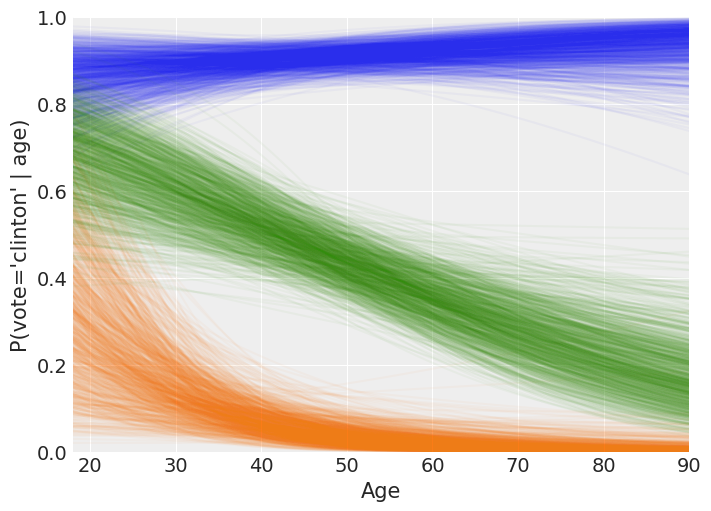

In [37]:
_, ax = plt.subplots(figsize=(7, 5))

for i, party in enumerate(["democrat", "republican", "independent"]):
    # Which rows in new_data correspond to party?
    idx = new_data.index[new_data["party_id"] == party].tolist()
    ax.plot(age, vote_posterior[idx], alpha=0.04, color=f"C{i}")

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age", fontsize=15)
ax.set_ylim(0, 1)
ax.set_xlim(18, 90);

The following is a rough interpretation of the information contained in the plot we've just created.

According to our logistic model, the mean probability of voting for Clinton is almost always 0.8 or greater for Democrats no matter the age (blue line). Also, the older the person, the closer the mean probability of voting Clinton to 1.

On the other hand, Republicans have a non-zero probability of voting for Clinton when they are young, but it tends to zero for older persons (green line). We can also note the high variability of P(vote = 'Clinton') for young Republicans. This reflects our high uncertainty when estimating this probability and it is due to the small amount of Republicans in that age range plus there are only 5 Republicans out of 97 voting for Clinton in the dataset.

Finally, the mean probability of voting Clinton for the independents is around 0.7 for the youngest and decreases towards 0.2 as they get older (orange line). Since the spread of the lines is similar along all the ages, we can conclude our uncertainty in this estimate is similar for all the age groups.

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Nov 14 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.21.2
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
bambi     : 0.6.3
arviz     : 0.11.4
matplotlib: 3.4.3
pandas    : 1.3.1

Watermark: 2.1.0

